# Convolutional Net on MNIST and CIFAR-10

In [303]:
from torchvision import datasets, transforms
from torch import nn
from torch.utils.data import DataLoader
import torch
from torch import optim

In [182]:
from rgutils.plot_utils import plot_learning_curve

%matplotlib inline

In [308]:
%%writefile rgutils/torch_utils.py

import torch
from math import floor


def train_epoch(model, dataloader, input_size, device, optimizer, criterion,):
    '''
    Makes 1 training epoch and evaluates train error (for multi-class classification)
    -----
    Returns training loss and accuracy   
    '''
    model.train()
    
    running_loss = 0
    num_correct = 0
    for img_data,img_labels in dataloader:
        images = img_data.view(-1, *input_size).to(device)
        labels = img_labels.to(device)
        
        y_pred = model(images)
        loss = criterion(y_pred, labels,)
        
        _,y_pred_labels = torch.max(y_pred, dim=1)
        num_correct += torch.sum(labels == y_pred_labels).item()
        running_loss += loss.item() * labels.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = num_correct / len(train_loader.dataset) * 100
    return epoch_loss, epoch_acc


def eval_epoch(model, dataloader, input_size, device, criterion):
    '''
    Evaluate validation error after an epoch of training
    '''
    model.eval()
    running_loss = 0
    num_correct = 0
    for img_data, img_labels in dataloader:
        images = img_data.view(-1, *input_size).to(device)
        labels = img_labels.to(device)
        
        y_pred = model(images)
        loss = criterion(y_pred, labels,)
        
        _,y_pred_labels = torch.max(y_pred, dim=1)
        num_correct += torch.sum(labels == y_pred_labels).item()
        running_loss += loss.item() * labels.size(0)
    
    val_loss = running_loss / len(val_loader.dataset)
    val_acc = num_correct / len(val_loader.dataset) * 100
    return val_loss, val_acc


def run_training(num_epoch, model, dataloaders, input_size, optimizer, criterion, 
                 device, history=None, print_stats=True):
    '''
    Runs training for a specified number of epochs
    '''
    if history is not None:
        start_epoch = max(history['epoch']) + 1
        num_epoch = num_epoch + start_epoch
    else:
        history = {'epoch': [], 'train_score': [], 'val_score': [], 'train_loss': [], 'val_loss': []}
        start_epoch = 0
    for ep in range(start_epoch, num_epoch):
        if print_stats:
            print('='*10, 'Epoch', ep, '='*10)

        train_loss, train_score = train_epoch(model, dataloaders['train'], input_size, device, optimizer, criterion)
        val_loss, val_score = eval_epoch(model, dataloaders['val'], input_size, device, criterion)
        history['epoch'].append(ep)
        history['train_score'].append(train_score), history['train_loss'].append(train_loss)
        history['val_score'].append(val_score), history['val_loss'].append(val_loss)
        
        if print_stats:
            print('%7d Loss | Score' % ep)
            print('Train %.4f | %.1f' % (train_loss, train_score))
            print('Valid %.4f | %.1f' % (val_loss, val_score))
            print()
    return model, history


def get_output_size(input_size, kernel_size, padding, stride):
    '''
    Calculates an output size of a feature map given input dimension
    '''
    return floor((input_size - kernel_size + 2*padding) / stride) + 1

Overwriting rgutils/torch_utils.py


In [184]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## MNIST

#### Prepare Data

In [10]:
MNIST_DIR = './mnist_data/'
BATCH_SIZE = 64

In [13]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.45,), (0.2,)),
])

train_loader = DataLoader(datasets.MNIST(MNIST_DIR, train=True, download=False, 
                                         transform=mnist_transform),
                          batch_size=BATCH_SIZE, shuffle=True)

val_loader = DataLoader(datasets.MNIST(MNIST_DIR, train=False, download=False,
                                       transform=mnist_transform),
                          batch_size=BATCH_SIZE, shuffle=True)

data_loaders = {
    'train': train_loader,
    'val': val_loader,
}

#### Define Network


In [39]:
input_width,input_height,input_channels = 28,28,1
num_classes = 10

In [81]:
inp = 28
for l in range(3):
    out = get_output_size(inp, 3, 1, 1)
    out = get_output_size(out, 2, 0, 2)
    inp = out
print(out)

3


In [97]:
class ConvNet(nn.Module):
    '''
    A simple convnet
    '''
    def __init__(self,):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.max_pool = nn.MaxPool2d(2, stride=2, padding=0)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(out * out * 64, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, x):
        hidden1 = self.relu(self.conv1(x))
        pool1 = self.max_pool(hidden1)
        hidden2 = self.relu(self.conv2(pool1))
        pool2 = self.max_pool(hidden2)
        hidden3 = self.relu(self.conv3(pool2))
        pool3 = self.max_pool(hidden3)
        reshaped = pool3.view(-1, out * out * 64)
        fc1 = self.fc1(reshaped)
        return self.softmax(fc1)

In [98]:
net = ConvNet().to(device)

print(net)

ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (softmax): LogSoftmax()
)


#### Train and Evaluate

In [89]:
learning_rate = 0.1
num_epoch = 10
input_dims = (input_channels, input_width, input_height)

In [90]:
optimizer = optim.SGD(net.parameters(), learning_rate)
criteria = nn.CrossEntropyLoss()

In [91]:
model, training = run_training(num_epoch, net, data_loaders, input_dims, optimizer, criteria, device,)

========== Epoch 0 ==========
      0 Loss | Score
Train 0.1732 | 94.6
Valid 0.0854 | 97.3

========== Epoch 1 ==========
      1 Loss | Score
Train 0.0456 | 98.6
Valid 0.0448 | 98.5

========== Epoch 2 ==========
      2 Loss | Score
Train 0.0331 | 99.0
Valid 0.0380 | 98.8

========== Epoch 3 ==========
      3 Loss | Score
Train 0.0257 | 99.2
Valid 0.0272 | 99.1

========== Epoch 4 ==========
      4 Loss | Score
Train 0.0212 | 99.3
Valid 0.0267 | 99.1

========== Epoch 5 ==========
      5 Loss | Score
Train 0.0163 | 99.5
Valid 0.0313 | 98.9

========== Epoch 6 ==========
      6 Loss | Score
Train 0.0144 | 99.5
Valid 0.0286 | 99.2

========== Epoch 7 ==========
      7 Loss | Score
Train 0.0119 | 99.6
Valid 0.0327 | 99.0

========== Epoch 8 ==========
      8 Loss | Score
Train 0.0099 | 99.7
Valid 0.0257 | 99.2

========== Epoch 9 ==========
      9 Loss | Score
Train 0.0075 | 99.8
Valid 0.0334 | 99.0



#### Reporting

After 4 epochs of training basic net achieves over 99%. 
Let's try CIFAR-10 instead

## CIFAR-10

#### Data Loader

In [185]:
BATCH_SIZE = 64
CIFAR_DIR = './CIFAR10'

In [186]:
cifar_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49,), (0.21,))
])

In [187]:
train_loader = DataLoader(datasets.CIFAR10(CIFAR_DIR, train=True, transform=cifar_transforms, download=True),
                          batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(datasets.CIFAR10(CIFAR_DIR, train=False, transform=cifar_transforms, download=True),
                          batch_size=BATCH_SIZE, shuffle=True)
data_loaders = {
    'train': train_loader,
    'val': val_loader,
}

Files already downloaded and verified
Files already downloaded and verified


#### Net

In [188]:
input_width,input_height,input_channels = 32,32,3
num_classes = 10

In [307]:
begin = 32
filters = [1,3,3,]
for f in filters:
    out = get_output_size(begin, f, 0, 1)
    out = get_output_size(out, 2, 0, 2)
    begin = out
    
conv_out_size = out * out * 64
print(out, conv_out_size)

2 256


In [297]:
import math
from torch import nn


class ConvNet(nn.Module):
    '''
    A simple convnet
    '''
    def __init__(self,):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=1)
#         self.conv1_2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
#         self.conv2_2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.conv3_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.max_pool = nn.MaxPool2d(2, stride=2, padding=0)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(conv_out_size, num_classes)
#         self.fc2 = nn.Linear(256, 100)
#         self.fc3 = nn.Linear(100, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
#         self.dropout = nn.Dropout2d(0.5)
        
        
    def forward(self, x):
        hidden1 = self.relu(self.conv1(x))
#         hidden1 = self.relu(self.conv1_2(hidden1))
        hidden1 = self.batchnorm1(hidden1)
        pool1 = self.max_pool(hidden1)
        hidden2 = self.relu(self.conv2(pool1))
#         hidden2 = self.relu(self.conv2_2(hidden2))
        hidden2 = self.batchnorm2(hidden2)
        pool2 = self.max_pool(hidden2)
        hidden3 = self.relu(self.conv3(pool2))
#         hidden3 = self.relu(self.conv3_2(hidden3))
        hidden3 = self.batchnorm3(hidden3)
        pool3 = self.max_pool(hidden3)
        reshaped = pool3.view(-1, conv_out_size)
        fc1 = self.softmax(self.fc1(reshaped))
#         fc2 = self.relu(self.fc2(fc1))
#         fc3 = self.softmax(self.fc3(fc2))
        return fc1

In [298]:
net = ConvNet().to(device)

print(net)

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
  (softmax): LogSoftmax()
)


#### Train and Evaluate

In [299]:
learning_rate = 0.01
num_epoch = 30
input_dims = (input_channels, input_width, input_height)

In [300]:
optimizer = optim.SGD(net.parameters(), learning_rate,)
# optimizer = optim.Adadelta(net.parameters(), learning_rate)
# optimizer = optim.RMSprop(net.parameters(), learning_rate)
# optimizer = optim.Adam(net.parameters(), learning_rate)
criteria = nn.CrossEntropyLoss()

In [301]:
model, history = run_training(num_epoch, net, data_loaders, input_dims, optimizer, criteria, device,
                             history=None)

========== Epoch 0 ==========
      0 Loss | Score
Train 1.4288 | 49.7
Valid 1.1992 | 57.6

========== Epoch 1 ==========
      1 Loss | Score
Train 1.0926 | 61.8
Valid 1.2389 | 55.7

========== Epoch 2 ==========
      2 Loss | Score
Train 0.9624 | 66.7
Valid 1.0506 | 62.8

========== Epoch 3 ==========
      3 Loss | Score
Train 0.8851 | 69.4
Valid 1.0129 | 64.8

========== Epoch 4 ==========
      4 Loss | Score
Train 0.8279 | 71.4
Valid 0.9263 | 67.6

========== Epoch 5 ==========
      5 Loss | Score
Train 0.7819 | 72.9
Valid 1.0740 | 63.5

========== Epoch 6 ==========
      6 Loss | Score
Train 0.7408 | 74.1
Valid 0.8930 | 68.9

========== Epoch 7 ==========
      7 Loss | Score
Train 0.7113 | 75.4
Valid 1.0479 | 64.8

========== Epoch 8 ==========
      8 Loss | Score
Train 0.6802 | 76.4
Valid 0.8904 | 69.1

========== Epoch 9 ==========
      9 Loss | Score
Train 0.6530 | 77.5
Valid 0.8591 | 70.4

========== Epoch 10 ==========
     10 Loss | Score
Train 0.6278 | 78.3
Valid 1.

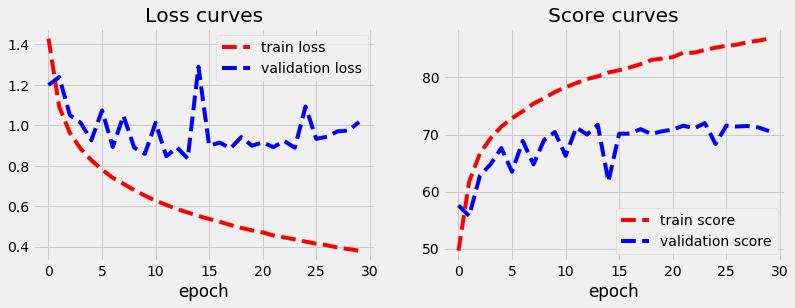

In [302]:
plot_learning_curve(history)

#### Reporting

Set parameters:
- SGD with learning rate at 0.1
- No batchnorm
- batch size 64
- all kernel filters at 3, padding=1, stride=1
- Convolutional layers with filters [3,16], [16,32] and [32,64]
- Convolutional blocks are 2 convolutions with number of filters of [i, o] and [o, o]
- Fully connected layers' units are [1024,256], [256,100] and [100,10]

|Epochs|Architecture|Max val score|Corresponding train score|
|---|---|---|---|
|20|3 conv layers + 1 fc layer|0.659|0.709|
|20|3 conv layers + 2 fc layers|0.679|0.747|
|30|3 conv layers + 3 fc layers|0.691|0.817|
|30|3 conv blocks + 3 fc layers|0.71|0.792|
|30|3 conv blocks + batchnorm + 3 fc layers|0.745|0.964|
|30|3 conv layers + batchnorm + 3 fc layers|0.737|0.924|
|30|3 conv layers + batchnorm + 1 fc layer|0.72|0.848|